## Lista 4 - Aprendizagem de máquina probabilístico
- Aluno: Lucas Rodrigues Aragão - Graduação 538390

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import norm, gamma

## Modelos

### PPCA Usando algoritmo EM

1. Inicializar os parâmetros $\mu =\frac{1}{N}\sum^N_{i=1}x_i$, $W^{(0)}$, $(\sigma^2)^{(0)}$

2. Repetir até convergência 

    Expectation:
    $$\mathbb{E}[z_i] = M^{-1} W^T (x_i - \mu)$$
    $$M = W^T W + \sigma^2 I$$
    $$\mathbb{E}[z_i z_i^T] = \sigma^2 M^{-1} + \mathbb{E}[z_i] \mathbb{E}[z_i]^T$$
    

    Maximization: 
    $$W = \big[\sum^N_{i=1} (x_i - \mu) \mathbb{E}[z_i]^T \big] \big[\sum^N_{i=1} \mathbb{E}[z_i z_i^T] \big]$$

    $$\sigma^2 = \frac{1}{ND} \sum^N_{i=1} \{ || x_i - \mu||^2 - 2 \mathbb{E} W^T (x_i - \mu) + \text{Tr}(\mathbb{E} [z_i z_i^T] W^T W)\}$$

A projeção probabilística dos dados é dada por:
    $$p(z_i| x_i) = \mathcal{N}(z_i| \hat{M}^{-1} W^T (x - \hat{\mu}), \sigma^2 \hat{M}^{-1})$$
Reconstrução probabilística das projeções é:
    $$p(x_i| z_i) =  \mathcal{N}(x_i| \hat{W}z_i + \hat{\mu}, \sigma^2 I)$$    

In [2]:
class PPCA_EM:
    def __init__(self, mu, W0,sigma0):
        self.mu = mu
        self.W = W0
        self.sigma2 = sigma0
        self.Ez = None
        self.Ezz = None

    def expectation(self, xi, index):
        W = self.W
        self.M = W.T @ W + self.sigma2 * np.eye(W.shape[1])
        M_inv = np.linalg.inv(self.M)
        EzI = M_inv @ W.T @ (xi - self.mu)
        self.Ez[index] = EzI
        self.Ezz[index] = self.sigma2 * M_inv + np.outer(EzI, EzI)
        
    def maximization(self, X):
        mu = self.mu
        Ez = self.Ez
        Ezz = self.Ezz
        x = np.asarray(X)
        N, D = x.shape
        
        X_centered = x - mu  

        # soma dos (x_i - mu) E[z_i]^T
        M1 = X_centered.T @ Ez 
        # soma das E[z_i z_i^T]
        M2 = np.sum(self.Ezz, axis=0) 

        W = M1 @ np.linalg.inv(M2)
        self.W = W

        #||x_i - mu||^2
        term1 = np.sum(X_centered**2, axis=1)  

        # -2 * E[z_i]^T W^T (x_i - mu)
        term2 = -2 * np.sum((Ez @ W.T) * X_centered, axis=1)  

        # Tr(E[z_i z_i^T] W^T W)
        WtW = W.T @ W 
        term3 = np.array([np.trace(Ezz[i] @ WtW) for i in range(N)])  
        # soma e média
        sigma2 = np.sum(term1 + term2 + term3) / (N * D)
        self.sigma2 = sigma2

    def train(self, X, epochs):
        N = X.shape[0]
        q = self.W.shape[1]
        self.Ez = np.zeros((N, q))
        self.Ezz = np.zeros((N, q, q))

        for epoch in range(epochs):
            #print(f"Epoch: {epoch +1}")
            for index, xi in enumerate(X):
                self.expectation(xi, index)
            self.maximization(X)
        
    def project(self, X, noisy=True):
        M_inv = np.linalg.inv(self.M)
        x = np.asarray(X)
        N = x.shape[0]

        mean = (M_inv @ self.W.T @ (x - self.mu).T).T
        cov = self.sigma2 * M_inv

        if noisy:
            pzx = np.array([
                np.random.multivariate_normal(mean[i], cov)
                for i in range(N)
            ])
        else:
            pzx = mean  
        return pzx


    def reconstruct(self, Z):
        W = np.asarray(self.W)
        mean = Z @ W.T + self.mu

        X_samples = mean  

        return X_samples


    def generate(self, n_samples):
        q = self.W.shape[1]           
        z = np.random.randn(n_samples, q)

        mu = self.mu.reshape(-1)

        mean = z @ self.W.T + mu  

        X_samples = mean 

        return X_samples

### Inferência Variacional para gaussiana univariada

1. Escolher hiperparâmetros das prioris: $\mu_0, \kappa_0, a_0 , b_0$

2. Calcular valores ótimos para $\mu_N, a_N$

$$\mu_N = \frac{\kappa_0 \mu_0 + \sum^N_{i=1} x_i}{ \kappa_0 + N}$$

$$a_N = a_0 + \frac{N+1}{2} $$

3. Inicializar parâmetros variacionais: $$\kappa^{(0)}_N, b^{(0)}_N$$ 

4. Repetir até convergir:

$$\kappa_N = (\kappa_0 + N) \frac{a_N}{b_N}$$

$$b_N = b_0 + \frac{\kappa_0}{2} \big[ \frac{1}{\kappa_N}  + (\mu_N - \mu_0)^2 \big] + \frac{1}{2} \sum^N_{i=1} \big[ \frac{1}{\kappa_N} + (x_i - \mu_N)^2 \big]$$

5. Definit $p(\mu, \tau| D) \approx q(\mu, \tau) = q_{\mu}(\mu) q_{\tau} (\tau)$, sendo $q_{\mu}(\mu) = \mathcal{N} (\mu| \mu_N, \kappa^{-1}_N)$ e $q_{\tau} (\tau) = Ga(\tau| a_N, b_N)$

In [ ]:
class InfVarGauss:
    def __init__(self, mu0, kappa0, a0, b0):
        self.mu = mu0
        self.kappa = kappa0
        self.a = a0
        self.b = b0
    
    def train(self, X, epochs):
        x = np.asarray(X)
        N = X.shape[0]
        # passo 2 encontrar os valores otimos para mu e kappa
        k0 = self.kappa
        mu0 = self.mu
        b0 = self.b

        muN = (k0 * mu0 + np.sum(X))/(k0 + N)
        aN = self.a + (N+1)/2
        self.mu = muN
        self.a = aN 

        # passo 3 inicializar os parametros kN e bN
        kN = self.kappa
        bN = self.b

        # passo 4 repetir ate convergencia 
        diff = (muN - mu0)**2
        var = (x - muN) **2
        for _ in range(epochs):
            kN = (k0 + N) * aN/bN

            term2 = k0/2 * (1/kN + diff)
            term3 = 1/2 * np.sum((1/kN) + var) 
            
            bN = b0 + term2 + term3

        self.b = bN
        self.kappa = kN


    def plot_posterior(self, color='green', label='q(μ,τ)'):
        muN, kN, aN, bN = self.mu, self.kappa, self.a, self.b

        mu_grid = np.linspace(-1, 1, 200)
        tau_grid = np.linspace(0.001, 15, 200)
        MU, TAU = np.meshgrid(mu_grid, tau_grid)

     
        qMuTal = norm.pdf(MU, loc=muN, scale=np.sqrt(1 / (kN * TAU)))
        q_tau = gamma.pdf(TAU, a=aN, scale=1 / bN)
        Q = qMuTal * q_tau
        Q /= Q.max() 

        cs = plt.contour(MU, TAU, Q, levels=6, colors=color, linewidths=1.5)
        
        plt.xlabel(r'$\mu$')
        plt.ylabel(r'$\tau$')
        plt.title(r'Distribuicao a posteriori: $q(\mu, \tau)$')

        plt.xlim(-1, 1)
        plt.xticks(ticks = [-1,0,1])
        plt.ylim(0, 15)
        plt.gca().set_aspect('auto')

        plt.text(0.9, 1.9, label, color=color, fontsize=10,
                ha='right', va='top', transform=plt.gca().transData)
        
        plt.show()

## Questões

### Questão 1

In [4]:
def show_images(originals, reconstructed, generated, n=5):
    plt.figure(figsize=(9, 6))
    for i in range(n):
        # original
        plt.subplot(3, n, i + 1)
        plt.imshow(originals[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.ylabel("Original", fontsize=12)

        # reconstruída
        plt.subplot(3, n, n + i + 1)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.ylabel("Reconstruída", fontsize=12)

        # gerada
        plt.subplot(3, n, 2 * n + i + 1)
        plt.imshow(generated[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.ylabel("Gerada", fontsize=12)

    plt.tight_layout()
    plt.show()

In [5]:
data_mnist = pd.read_csv("mnist_5.csv", header= None)
data_mnist

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6309,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
X_train, X_test = train_test_split(data_mnist, test_size=0.2, random_state=42)

In [7]:
X_min, X_max = X_train.min().min(), X_train.max().max()


In [8]:
def treinao(L):
    D = X_train.shape[1]

    A = np.random.randn(D, L)
    Q, _ = np.linalg.qr(A)
    W0 = Q

    mu = np.mean(X_train, axis=0)
    mu = np.asarray(mu)
    var_mean = np.mean(np.var(X_train, axis=0))
    sigma0 = 0.1 * var_mean

    model_mnist = PPCA_EM(mu=mu, W0=W0, sigma0=sigma0)
    model_mnist.train(X=X_train, epochs=300)

    n_samples = 5
    X_subset = X_test[:n_samples]
    Z = model_mnist.project(X=X_subset)
    reconstructedX = model_mnist.reconstruct(Z)
    generated = model_mnist.generate(n_samples=n_samples)

    reconstructedX_norm = np.clip((reconstructedX - X_min) / (X_max - X_min), 0, 1)
    
    generated_norm = np.clip((generated - X_min) / (X_max - X_min), 0, 1)

    X_subset = np.asarray(X_subset)
    print(f"Espaço Latente: {L}")
    show_images(X_subset, reconstructedX_norm, generated_norm, n=n_samples)

Espaço Latente: 2


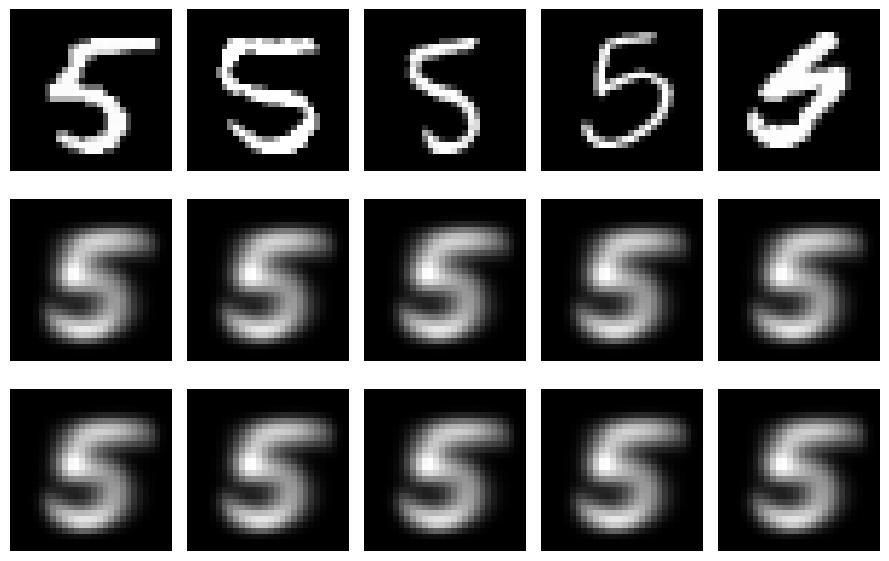

In [9]:
treinao(L = 2)

Espaço Latente: 10


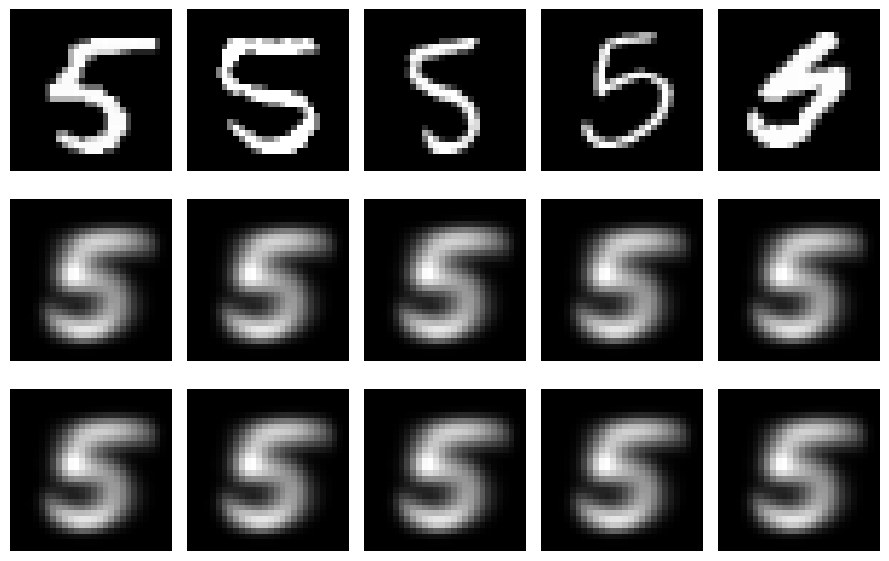

In [10]:
treinao(L = 10)

Espaço Latente: 20


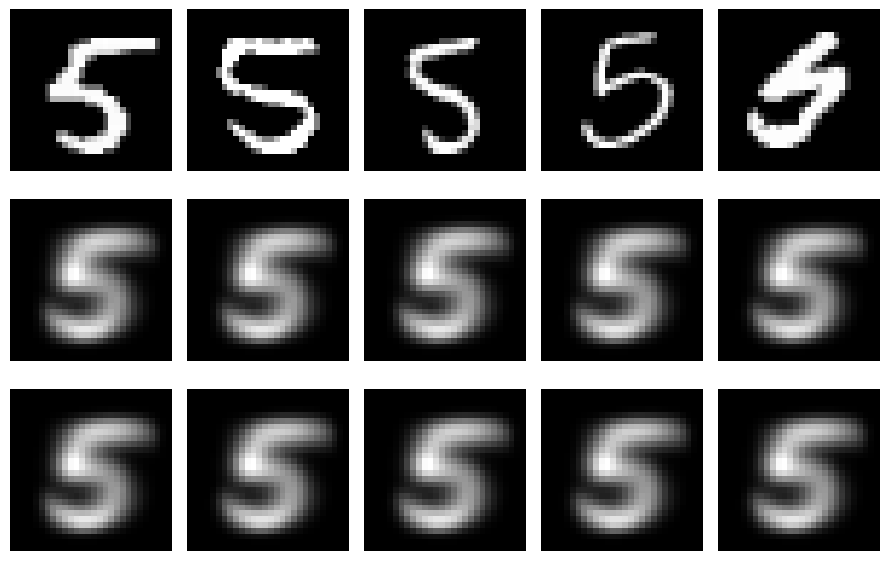

In [11]:
treinao(L = 20)

### Questão 2

In [18]:
data_gaussian = pd.read_csv("gaussian_1d.csv", header = None)
data_gaussian

,0
0,1.232343
1,2.705230
2,2.200096
3,0.934889
4,1.590868
...,...
495,2.401552
496,2.362734
497,1.980963
498,2.220321


In [39]:
def treinao2(x, epochs):
    x_min, x_max = np.min(x), np.max(x)
    x_norm = 2 * (x - x_min) / (x_max - x_min) - 1

    mu0   = x_norm.mean()
    kappa0 = 1e-2         
    a0 = 1.0              
    b0 = a0 * x_norm.var(ddof=0)  
    model_gaussian = InfVarGauss(mu0=mu0, kappa0= kappa0, a0= a0, b0= b0)
    model_gaussian.train(X = x_norm, epochs= epochs)
    model_gaussian.plot_posterior(color='green', label='')
    return x_norm

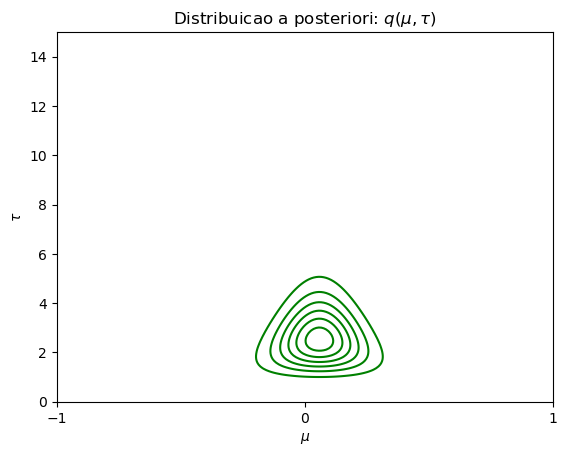

In [40]:
datap1 = np.asarray(data_gaussian[0:10])
x_norm = treinao2(datap1, 300)

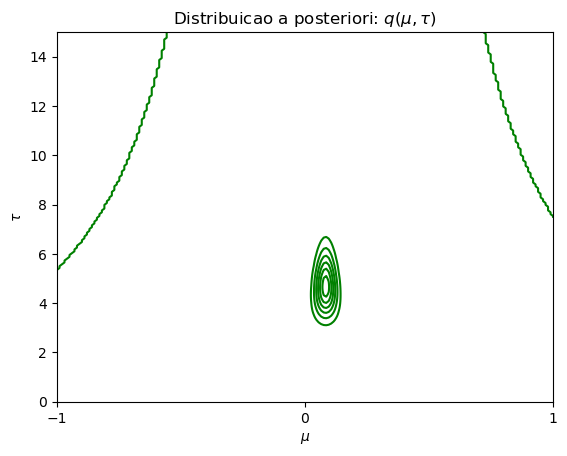

In [41]:
datap2 = np.asarray(data_gaussian[0:50])
model = treinao2(datap2, 300)

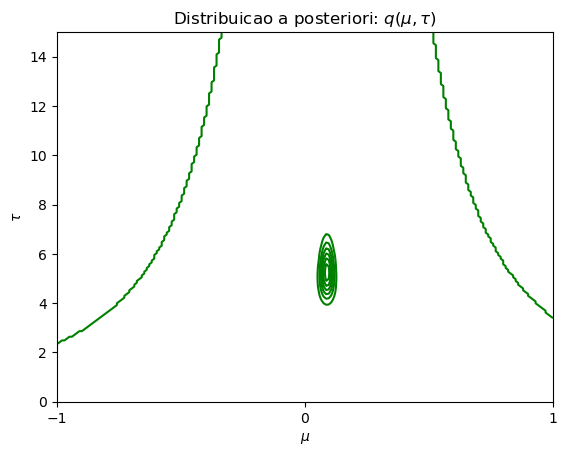

In [42]:
datap3 = np.asarray(data_gaussian[0:100])
model = treinao2(datap3, 300)

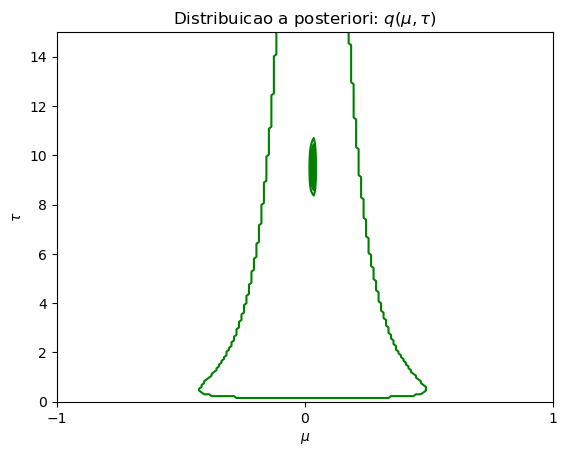

In [43]:
data = np.asarray(data_gaussian)
model = treinao2(data, 300)